In [2]:
!git clone https://github.com/google-research/simclr.git
!pip install -r simclr/requirements.txt
!pip install roboflow supervision opencv-python
!pip install lightly
!pip install scikit-learn
!pip install seaborn
!pip install torch torchvision torchaudio

fatal: destination path 'simclr' already exists and is not an empty directory.


  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)


ERROR: Could not find a version that satisfies the requirement tensorflow==1.15.4 (from versions: 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==1.15.4


In [3]:
""" Imports """
from sys import path
from roboflow import Roboflow
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import DataLoader
from lightly.models.modules import heads
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, ops
from PIL import Image
import matplotlib.patches as patches
import seaborn as sns

In [4]:
""" 
    Downloads dataset. Dataset should be in a folder named ./Firefighting-Device-Detection-6 if succesful.
"""

rf = Roboflow(api_key="qiCK5OxWVrfkhXhLxzSH") # TODO: replace by your Roboflow key
project = rf.workspace("yaid-pzikt").project("firefighting-device-detection")
version = project.version(6)
dataset = version.download("yolov7")

dataset_path = dataset.location  # Correct variable name

# Unzip dataset
os.system(f"unzip {dataset_path}/roboflow.zip -d {dataset_path}")
files = os.listdir(dataset_path)
print("Extracted files:", files)

loading Roboflow workspace...
loading Roboflow project...
Extracted files: ['data.yaml', 'README.dataset.txt', 'README.roboflow.txt', 'test', 'train', 'valid']


In [5]:
"""
    Dataset class for loading images and labels from Roboflow dataset
    Main use is to create views of the dataset for contrastive learning and prepare patches by taking labels and boxes in YOLO format.
"""
class SymbolDataset(Dataset):
    def __init__(self, dataset_path, img_size=224):
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=img_size, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
            transforms.GaussianBlur(kernel_size=9),
            transforms.ToTensor(),
        ])
        self.identity_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])

        # Load symbol patches from YOLO annotations
        self.patches, self.labels = self.load_patches(dataset_path)

    def load_patches(self, dataset_path):
        patches = []
        labels = []
        images_dir = os.path.join(dataset_path, "train", "images")
        labels_dir = os.path.join(dataset_path, "train", "labels")

        for img_file in os.listdir(images_dir):
            if not img_file.endswith(('.jpg', '.png')):
                continue

            img_path = os.path.join(images_dir, img_file)
            label_path = os.path.join(labels_dir, img_file.replace('.jpg', '.txt'))

            img = Image.open(img_path).convert("RGB")
            #print("Image shape:", img.size)
            w, h = img.size

            with open(label_path) as f:
                for line in f:
                    class_id, x_center, y_center, width, height = map(float, line.split())
                    x = (x_center - width/2) * w
                    y = (y_center - height/2) * h
                    width = width * w
                    height = height * h
                    patch = img.crop((x, y, x+width, y+height))
                    patches.append(patch)
                    labels.append(int(class_id))

        return patches, labels

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch = self.patches[idx]
        label = self.labels[idx]
        return self.transform(patch), self.transform(patch), label


In [6]:
"""
    Uses Pytorch Dataloader and shuffle patches to form finetuning training dataset. Adapt batch_size to needs.
"""
symbol_dataset = SymbolDataset(dataset.location)
dataloader = DataLoader(symbol_dataset, batch_size=64, shuffle=True)
print("Number of batches:", len(dataloader))

Number of batches: 41


In [7]:
"""
    SimCLR model. Using Resnet18 as backbone and projecting back into smaller dimension (128). Class source code inspired from ETH Zurich's example code of SimCLR and contrastive losses.
"""
class SimCLR(torch.nn.Module):
    def __init__(self, backbone=torchvision.models.resnet18(), classifier=False):
        super().__init__()
        self.backbone = backbone
        if not classifier:
            self.backbone.fc = torch.nn.Identity()
        self.projection_head = heads.SimCLRProjectionHead(
            input_dim=512,  # Resnet18 features have 512 dimensions.
            hidden_dim=512,
            output_dim=128,
        )

    def forward(self, x, dense=False):
        features = self.backbone(x)  
        # If dense is True, it means the user wants to work with the high dimensional space.
        if dense:
            return features
        else:
            features_flat = features.flatten(start_dim=1) 
            z = self.projection_head(features_flat)
            return z


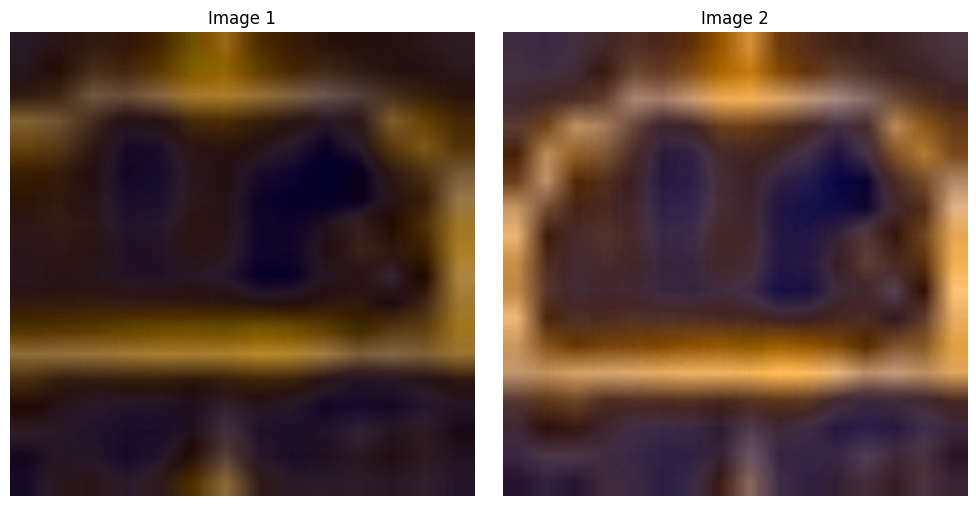

In [8]:
""" 
    Intermediate Sanity Check: 
    - Check if images from datasets make sense.
    - Check if symbol transforms are working as intended. (RandomResizedCrop, RandomHorizontalFlip, ColorJitter, GaussianBlur)
"""

import matplotlib.pyplot as plt
import numpy as np

(image1, image2, label) = symbol_dataset[0]
#print("image1 shape:", image1.shape)

image1_np = image1.permute(1, 2, 0)
image2_np = image2.permute(1, 2, 0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image1_np)
axes[0].axis('off')
axes[0].set_title("Image 1")

axes[1].imshow(image2_np)
axes[1].axis('off')
axes[1].set_title("Image 2")

plt.tight_layout()
plt.show()

In [11]:
"""
    Supervised Contrastive loss. We will use this function to train the model instead of the usual NT-Xent loss. The reason is that we have labels for the patches and can group them for more efficient learning.
"""

class SupConLoss(torch.nn.Module):
    def __init__(self, temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        """Computes the supervised contrastive loss. The idea here is that we already have labels for the images, rather than using contrastive loss 
        in an unsupervised setting we can use the labels to group the images of same labels. Faster convergence and better results.

        Args:
            features: Tensor of shape [batch_size, feature_dim]
            labels: Tensor of shape [batch_size]
        """
        device = features.device
        features = F.normalize(features, dim=1)
        similarity_matrix = torch.matmul(features, features.T) / self.temperature
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        logits_max, _ = torch.max(similarity_matrix, dim=1, keepdim=True)
        logits = similarity_matrix - logits_max.detach()  
        exp_logits = torch.exp(logits)
        log_probs = logits - torch.log(exp_logits.sum(dim=1, keepdim=True))
        loss = - (mask * log_probs).sum(dim=1) / mask.sum(dim=1)
        return loss.mean()

In [16]:
"""
    Training loop. The model is already pretrained on ImageNet, no need to do a lot of epochs.
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = SimCLR() # without any arguments, it uses Resnet18 as backbone and projects to 128 dimensions.
model.train()
model.to(device) 
criterion = SupConLoss(temperature=0.5) # Temperature is a hyperparameter that can be tuned.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6) # All parameters can be tuned, but from my quick experience doesn't change much overall behavior.
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

print(f"Training on {device}")
train_losses = []
for epoch in range(10):
    epoch_loss = 0
    for (view0, view1, labels) in dataloader:
        inputs = torch.cat([view0, view1], dim=0).to(device)
        z = model(inputs, dense=False)

        labels = labels.repeat(2)  # Because we have 2 views per sample

        loss = criterion(z, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
        print(f"Batch Loss {loss.item()}")
    avg_epoch_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_epoch_loss)
    scheduler.step(avg_epoch_loss)
    print(f"Epoch {epoch}: Avg Loss {avg_epoch_loss}")

# Save the model
torch.save(model.state_dict(), "simclr_finetuned_model_10_epochs_v2.pth")
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

Training on cuda
Batch Loss 4.389856815338135
Batch Loss 4.626405715942383
Batch Loss 4.634364128112793
Batch Loss 4.484976291656494
Batch Loss 4.74299430847168
Batch Loss 4.408934593200684
Batch Loss 4.576416015625
Batch Loss 4.273694038391113
Batch Loss 4.393497467041016
Batch Loss 4.31057071685791
Batch Loss 4.3440728187561035
Batch Loss 4.066946983337402
Batch Loss 4.3267717361450195
Batch Loss 4.117829322814941
Batch Loss 4.241878986358643
Batch Loss 4.139867782592773
Batch Loss 4.21014928817749
Batch Loss 4.237264156341553
Batch Loss 4.313948631286621
Batch Loss 4.135575294494629
Batch Loss 4.101288318634033
Batch Loss 4.092837333679199
Batch Loss 4.16091251373291
Batch Loss 4.095367431640625
Batch Loss 4.153482437133789
Batch Loss 4.037438869476318
Batch Loss 3.9721837043762207
Batch Loss 4.045470237731934
Batch Loss 4.058553218841553
Batch Loss 3.993354320526123
Batch Loss 3.980105400085449
Batch Loss 3.9904913902282715
Batch Loss 3.920517921447754
Batch Loss 4.016774654388428


KeyboardInterrupt: 

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


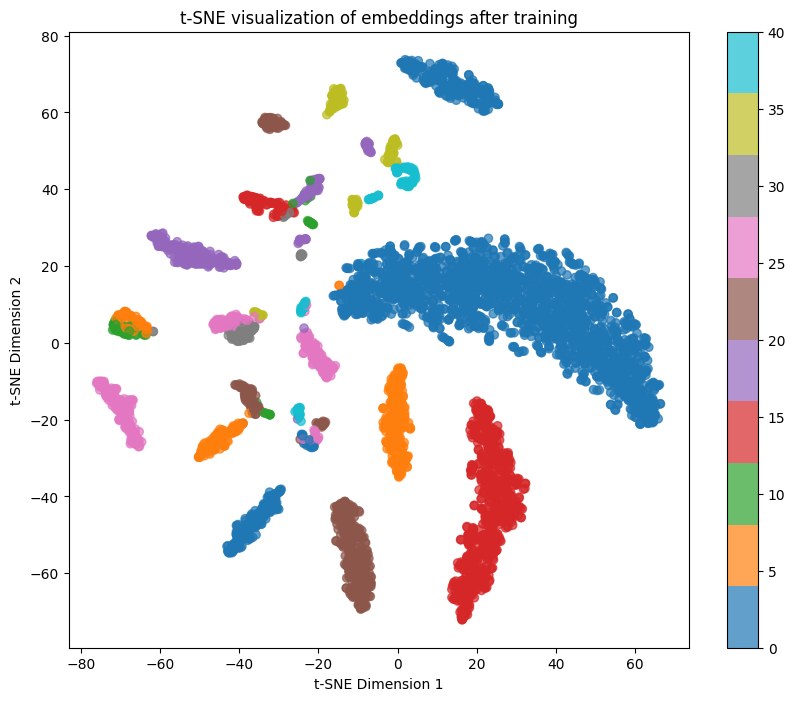

In [17]:
"""
    Optional: Visualize embeddings using t-SNE. This is a good way to see if the model has learned to separate the classes in the embedding space.
"""
def visualize_embeddings(model, dataloader, device):
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for (view0, view1, labels) in dataloader:
            inputs = torch.cat([view0, view1], dim=0).to(device)
            labels = labels.repeat(2) 
            
            z = model(inputs, dense=False)
            all_embeddings.append(z.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_embeddings = np.concatenate(all_embeddings, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    tsne = TSNE(n_components=2, random_state=42) # random state is "seed"
    reduced_embeddings = tsne.fit_transform(all_embeddings)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter)
    plt.title("t-SNE visualization of embeddings after training")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

model = SimCLR()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load("simclr_finetuned_model_10_epochs.pth"))
visualize_embeddings(model, dataloader, device)


In [18]:
"""
    Optional: Save embeddings to use in a downstream task. This is useful if you want to use the embeddings in a classifier or other model.
"""
model = SimCLR()
model.eval()
label_embeddings = {}
embeddings = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load("simclr_finetuned_model_10_epochs.pth"))

def cosine_similarity(a, b):
    return np.dot(a, b.T) / (np.linalg.norm(a) * np.linalg.norm(b))

with torch.no_grad():
    for idx, patch in enumerate(symbol_dataset.patches):
        #patch.save(f"testing/{idx}.png")
        label = symbol_dataset.labels[idx]
        if label not in label_embeddings:
            x = symbol_dataset.identity_transform(patch).unsqueeze(0).to(device)
            #print("x shape:", x.shape)
            #x2 = symbol_dataset.transform(patch).unsqueeze(0).to(device)
            embedding = model(x)
            label_embeddings[label] = embedding.cpu().numpy()
            embeddings.append(embedding.squeeze().cpu().numpy())

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


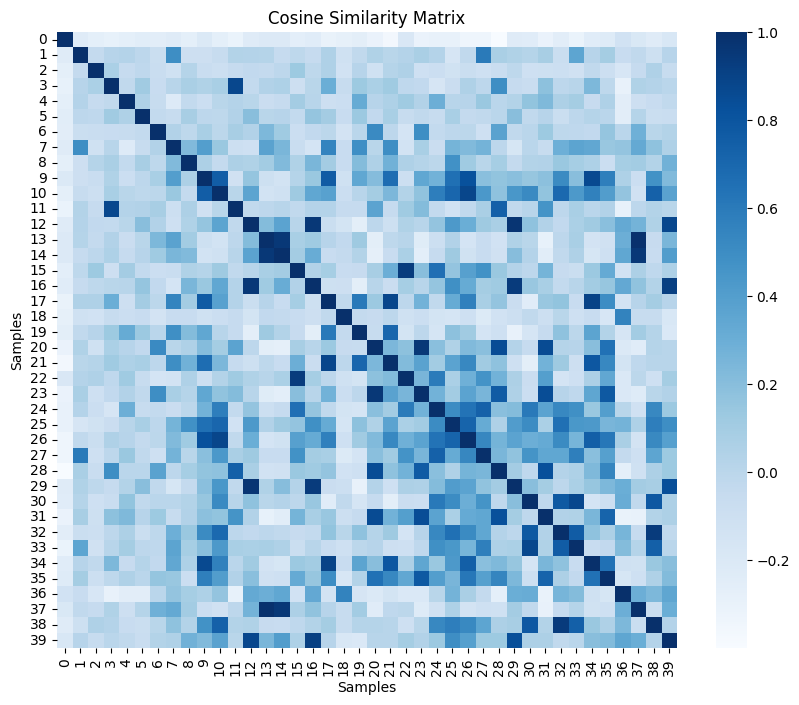

In [19]:
"""
    Optional: Visualize cosine similarity matrix. This is a good way to see if the model has learned to separate the classes in the embedding space. Requires previous step to be run.
"""

embeddings = np.array(embeddings)

similarity_matrix = np.dot(embeddings, embeddings.T)
norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
similarity_matrix /= (norms @ norms.T) 

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=False, cmap="Blues")
plt.title('Cosine Similarity Matrix')
plt.xlabel('Samples')
plt.ylabel('Samples')
plt.show()

In [9]:
"""
    Detector class. This class can be used to detect old symbols or new symbols in images. It uses a sliding window approach to detect symbols in images.

    # Built currently for GPU usage by parallelizing embeddings processing across possible windows.
    # Can be adapted for CPU usage by removing the device parameter and using the CPU.

    # The model parameter is the SimCLR model that was trained on the dataset.

    -> Main drawbacks: - Sliding window approach is slow and not efficient, prone to skipping symbols if too coarse.
                      - It achieves expected performance on finding symbols that are similar, however it is hard to predict the theoretical confidence (cosine similarity) threshold for new symbols.
"""

class SymbolDetector:
    def __init__(self, model, label_encodings, device='cpu',
                 window_size=224, scales=[1.0], stride=112, iou_threshold=0.7):
        self.device = device
        self.model = model.to(device)
        self.label_encodings = label_encodings
        self.window_size = window_size
        self.scales = scales
        self.stride = stride
        self.iou_threshold = iou_threshold
        self.identity_transform = transforms.Compose([
            transforms.Resize((window_size, window_size)),
            transforms.ToTensor()
        ]) 
    
    def get_sliding_windows(self, img_width, img_height):
        windows = []
        for scale in self.scales:
            scaled_size = int(self.window_size * scale)
            for y in range(0, img_height - scaled_size, self.stride):
                for x in range(0, img_width - scaled_size, self.stride):
                    windows.append((
                        x,  # left
                        y,  # top
                        x + scaled_size,  # right
                        y + scaled_size  # bottom
                    ))
        return windows
    
    def detect_symbols(self, image_path, conf_threshold=0.2, batch_size=32):
        img = Image.open(image_path).convert('RGB')
        img_width, img_height = img.size
        windows = self.get_sliding_windows(img_width, img_height)

        detections = []
        patches = []
        patch_coords = []

        for i, (left, top, right, bottom) in enumerate(windows):
            patch = img.crop((left, top, right, bottom))
            patch_tensor = self.identity_transform(patch).unsqueeze(0)  # Shape: [1, C, H, W]
            patches.append(patch_tensor)
            patch_coords.append((left, top, right, bottom))

        if not patches:
            return []

        num_patches = len(patches)
        batch_embeddings = []

        for i in range(0, num_patches, batch_size):
            batch_tensors = torch.cat(patches[i:i+batch_size], dim=0).to(self.device)
            print(f"Processing batch {i // batch_size + 1}/{(num_patches // batch_size) + 1}")
            with torch.no_grad():
                batch_embedding = self.model(batch_tensors, dense=False).cpu().numpy()  # Shape: [B, 128]
                batch_embeddings.append(batch_embedding)

        embeddings = np.vstack(batch_embeddings)
        label_encodings = np.stack(list(self.label_encodings.values()))  # Shape: [num_labels, 128]

        embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True) 
        label_enc_norm = label_encodings / np.linalg.norm(label_encodings.squeeze(1), axis=1, keepdims=True)  
        label_enc_norm = label_enc_norm.squeeze()

        if label_enc_norm.ndim == 1:
            label_enc_norm = label_enc_norm.reshape(1, -1)  

        similarities = np.dot(embeddings_norm, label_enc_norm.T)  
        best_label_indices = np.argmax(similarities, axis=1)
        best_confidences = np.max(similarities, axis=1)

        for i in range(len(windows)):
            if best_confidences[i] > conf_threshold:
                best_label = list(self.label_encodings.keys())[best_label_indices[i]]
                detections.append({
                    'box': list(patch_coords[i]),
                    'label': best_label,
                    'score': float(best_confidences[i])
                })

        if not detections:
            return []

        boxes = torch.tensor([d['box'] for d in detections], dtype=torch.float32)
        scores = torch.tensor([d['score'] for d in detections], dtype=torch.float32).view(-1)
        labels = [d['label'] for d in detections]
        keep_indices = ops.nms(boxes, scores, self.iou_threshold)
        return [detections[i] for i in keep_indices]
    
    @staticmethod
    def cosine_similarity(a, b):
        return np.dot(a, b.T) / (np.linalg.norm(a) * np.linalg.norm(b))

    def visualize_detections(self, image_path, detections):
        img = Image.open(image_path)
        fig, ax = plt.subplots(1)
        ax.imshow(img)
        
        for detection in detections:
            left, top, right, bottom = detection['box']
            label = detection['label']
            score = detection['score']

            rect = patches.Rectangle(
                (left, top), right-left, bottom-top,
                linewidth=1, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            
        plt.axis('off')
        plt.show()

In [10]:
"""
    Testing the detector on a sample image. The symbol chosen has never been seen in training. 
    Detection is achieved by computing similarity scores across all possible windows in the image. 
    Thresholding and applying NMS to get final detections.
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimCLR()
model.eval()
model.load_state_dict(torch.load("simclr_finetuned_model_10_epochs.pth"))
model.to(device)

# Get patch embedding for reference, technically any amount of patches can be used for reference. Previous try used all embeddings from the training labels.
# Here we take a new symbol to see how it handles 1-shot detection by having the embedding of the symbol.
with torch.no_grad():
    test_patch = r"./test_images/test_patch.png"
    patch_img = Image.open(test_patch).convert('RGB')
    patch = symbol_dataset.identity_transform(patch_img).unsqueeze(0) #resizes to 224x224
    #print("Patch shape:", patch.shape)
    patch_encoding= model(patch.to(device), dense=False)

    # Commented, can be used to check cosine similarity between patches of same symbols for sanity check.
    # test_patch2 = r"test_patch2.png"
    # patch_img2 = Image.open(./test_images/test_patch2).convert('RGB')
    # patch2 = symbol_dataset.identity_transform(patch_img2).unsqueeze(0) #resizes to 224x224
    # patch_encoding2= model(patch2.to(device), dense=False)
    # print("Cosine similarity:", SymbolDetector.cosine_similarity(patch_encoding.cpu().numpy(), patch_encoding2.cpu().numpy()))

label_embeddings = {0: patch_encoding.cpu().numpy()}

test_image = r"./test_images/landscaping-drawing-1.png"
image = Image.open(test_image)
plt.imshow(image)

detector = SymbolDetector(
    model,
    window_size=patch_img.size[0],
    label_encodings=label_embeddings,
    scales=[1.0], 
    stride=32,
    iou_threshold=0.1,
    device=device
)

detections = detector.detect_symbols(test_image, conf_threshold=0.99)
detector.visualize_detections(test_image, detections)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


NameError: name 'device' is not defined

In [ ]:
"""
    Thoughts for further work:
    - The model seems to handle well learning positive samples and separating them in the embedding space. However, it is easy to have high similarity on background patches.
    - The detector suffers from the sliding window approach. Slow and inefficient. Further work would use other techniques to predict the bounding boxes (YOLO, Faster-RCNN ?) to get the boxes and use simCLR to classify.
    
    - For a general code, it is quite impressive how well fares simCLR at embedding symbols on a dataset. With smart techniques, it could definitely be used for powerful downstream tasks.

    Open questions -> Detection of new symbols ? Confidence thresholding ? Bounding boxes without knowing what we are looking for ?
"""